# PID TUNING


In [1]:
# Cell 1: Imports and Dynamics (with Simplified, Stable Model)
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# =============================================================================
# --- Physical Constants and Parameters ---
# =============================================================================
g = 9.81
m = 2.0
l = 0.25
Ixx = 7.5e-3
Iyy = 7.5e-3
Izz = 2.3e-2

# --- Using standard, simplified motor coefficients for stability ---
THRUST_COEFFICIENT = 2e-6  # Relates motor speed (rad/s)^2 to thrust (N)
DRAG_COEFFICIENT = 1e-7    # Relates motor speed (rad/s)^2 to drag torque

# =============================================================================
# --- Main Dynamics Function (Simplified) ---
# =============================================================================
def quadcopter_dynamics(t, state, motor_speeds):
    # --- 1. Unpack State ---
    x, y, z, phi, theta, psi, u, v, w_body, p, q, r = state
    motor_speeds_sq = motor_speeds**2

    # --- 2. Calculate Forces and Torques (Simplified Model) ---
    forces = THRUST_COEFFICIENT * motor_speeds_sq
    total_thrust = np.sum(forces)
    
    # Motor layout: 1:FL, 2:FR, 3:RR, 4:RL in 'X' config
    tau_phi   = (forces[3] + forces[0] - forces[1] - forces[2]) * l
    tau_theta = (forces[2] + forces[3] - forces[0] - forces[1]) * l
    tau_psi   = DRAG_COEFFICIENT * (-motor_speeds_sq[0] + motor_speeds_sq[1] - motor_speeds_sq[2] + motor_speeds_sq[3])

    # --- 3. Equations of Motion ---
    c_phi, s_phi = np.cos(phi), np.sin(phi)
    c_theta, s_theta = np.cos(theta), np.sin(theta)
    c_psi, s_psi = np.cos(psi), np.sin(psi)
    tan_theta = np.tan(theta)

    R = np.array([
        [c_theta*c_psi, s_phi*s_theta*c_psi - c_phi*s_psi, c_phi*s_theta*c_psi + s_phi*s_psi],
        [c_theta*s_psi, s_phi*s_theta*s_psi + c_phi*c_psi, c_phi*s_theta*s_psi - s_phi*c_psi],
        [-s_theta, s_phi*c_theta, c_phi*c_theta]
    ])
    pos_dot = R @ np.array([u, v, w_body])

    if abs(c_theta) < 1e-9: c_theta = np.sign(c_theta) * 1e-9
    euler_rate_transform = np.array([
        [1, s_phi*tan_theta, c_phi*tan_theta],
        [0, c_phi, -s_phi],
        [0, s_phi/c_theta, c_phi/c_theta]
    ])
    ptp_dot = euler_rate_transform @ np.array([p, q, r])

    uvw_dot = np.array([
        r*v - q*w_body - g*s_theta,
        p*w_body - r*u + g*s_phi*c_theta,
        q*u - p*v + g*c_phi*c_theta - total_thrust / m
    ])

    p_dot = ((Iyy - Izz)/Ixx)*q*r + tau_phi/Ixx
    q_dot = ((Izz - Ixx)/Iyy)*p*r + tau_theta/Iyy
    r_dot = ((Ixx - Iyy)/Izz)*p*q + tau_psi/Izz

    # --- 4. Assemble Derivative Vector ---
    state_dot = np.concatenate([pos_dot, ptp_dot, uvw_dot, [p_dot, q_dot, r_dot]])
    return state_dot

print("Cell 1 executed: Dynamics model with SIMPLIFIED motor physics loaded.")

Cell 1 executed: Dynamics model with SIMPLIFIED motor physics loaded.


In [2]:
# Cell 2: PID Controller and Simulation Function
class PIDController:
    """A simple PID controller."""
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.reset()

    def reset(self):
        self._integral = 0
        self._prev_error = 0

    def update(self, error, dt):
        if dt <= 0: return 0
        self._integral += error * dt
        self._integral = np.clip(self._integral, -5.0, 5.0) # Anti-windup
        derivative = (error - self._prev_error) / dt
        output = self.Kp * error + self.Ki * self._integral + self.Kd * derivative
        self._prev_error = error
        return output

def run_simulation(gains, target_pos, duration, return_history=False):
    """
    Runs the simulation with the simplified dynamics and stable control architecture.
    """
    Kp_alt, Kd_alt, Kp_xy, Kd_xy, Kp_ang, Kd_ang = gains
    
    alt_controller = PIDController(Kp=Kp_alt, Ki=0.5, Kd=Kd_alt)
    x_controller = PIDController(Kp=Kp_xy, Ki=0.0, Kd=Kd_xy)
    y_controller = PIDController(Kp=Kp_xy, Ki=0.0, Kd=Kd_xy)
    phi_controller = PIDController(Kp=Kp_ang, Ki=0.0, Kd=Kd_ang)
    theta_controller = PIDController(Kp=Kp_ang, Ki=0.0, Kd=Kd_ang)
    psi_controller = PIDController(Kp=0.5, Ki=0.0, Kd=0.1)

    initial_state = np.zeros(12)
    target_x, target_y, target_z = target_pos
    
    # Using the new THRUST_COEFFICIENT for a stable hover calculation
    hover_w = np.sqrt(m * g / (4 * THRUST_COEFFICIENT))
    
    def dynamics_with_controller(t, state):
        x, y, z, phi, theta, psi, u, v, w_body, p, q, r = state
        
        dt = t - getattr(dynamics_with_controller, 'last_time', 0.0)
        if getattr(dynamics_with_controller, 'last_time', -1) < 0: dt=0.02
        dynamics_with_controller.last_time = t

        alt_error = target_z - z
        alt_adj = alt_controller.update(alt_error, dt)
        base_speed = hover_w + alt_adj

        x_error = target_x - x
        ax_des = x_controller.update(x_error, dt)
        y_error = target_y - y
        ay_des = y_controller.update(y_error, dt)
        phi_des = np.clip((-ay_des / g), -0.3, 0.3)
        theta_des = np.clip((ax_des / g), -0.3, 0.3)
        
        phi_error = phi_des - phi
        phi_adj = phi_controller.update(phi_error, dt)
        
        theta_error = theta_des - theta
        theta_adj = theta_controller.update(theta_error, dt)
        
        psi_error = 0 - psi
        psi_adj = psi_controller.update(psi_error, dt)
        
        w1 = base_speed + theta_adj - phi_adj - psi_adj
        w2 = base_speed + theta_adj + phi_adj + psi_adj
        w3 = base_speed - theta_adj + phi_adj - psi_adj
        w4 = base_speed - theta_adj - phi_adj + psi_adj
        
        motor_speeds = np.clip(np.array([w1, w2, w3, w4]), 0, 1200)

        return quadcopter_dynamics(t, state, motor_speeds)

    sol = solve_ivp(
        dynamics_with_controller, [0, duration], initial_state,
        t_eval=np.linspace(0, duration, int(duration * 50))
    )

    position_error = np.sum(np.abs(target_pos - sol.y[:3, :].T))
    control_effort = np.sum(np.abs(sol.y[3:6,:]))
    cost = position_error + control_effort * 0.5
    
    if np.any(np.isnan(sol.y)): return 1e6
    if return_history: return sol, cost
    return cost

print("Cell 2 executed: Simulation wrapper updated for new hover calculation.")

Cell 2 executed: Simulation wrapper updated for new hover calculation.


In [3]:
# Cell 3: PID Optimizer
def optimize_all_gains():
    """
    Finds optimal gains for the new, stable control architecture.
    """
    print("🚀 Starting PID optimization for the new control architecture...")
    
    target_position = np.array([2.0, 3.0, 5.0])
    sim_duration = 10.0

    # These initial guesses are suitable for the new speed-based controller
    # [Kp_alt, Kd_alt, Kp_xy, Kd_xy, Kp_ang, Kd_ang]
    initial_gains = [3.0,  4.0,  0.8,  1.5,  0.5,  0.3]
    bounds = [(0.1, 10), (0.1, 10), # Altitude gains
              (0.1, 5), (0.1, 5),   # XY gains
              (0.1, 5), (0.1, 5)]   # Angle gains

    objective_function = lambda gains: run_simulation(gains, target_position, sim_duration)

    result = minimize(
        objective_function,
        initial_gains,
        method='SLSQP',
        bounds=bounds,
        options={'disp': True, 'maxiter': 75}
    )

    print("\n✅ Optimization complete!")
    if result.success:
        final_gains = result.x
        print(f"🔹 Final cost: {result.fun:.4f}")
        print("🔹 Final Gains [Kp_alt, Kd_alt, Kp_xy, Kd_xy, Kp_ang, Kd_ang]:")
        print(f"   {np.round(final_gains, 4)}")
        return final_gains
    else:
        print(f"⚠️ Optimization failed: {result.message}")
        return None

# --- Run the full Optimization ---
optimal_gains = optimize_all_gains()

🚀 Starting PID optimization for the new control architecture...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 34311.56248368483
            Iterations: 2
            Function evaluations: 15
            Gradient evaluations: 2

✅ Optimization complete!
🔹 Final cost: 34311.5625
🔹 Final Gains [Kp_alt, Kd_alt, Kp_xy, Kd_xy, Kp_ang, Kd_ang]:
   [1.4113 1.8634 3.1009 1.5942 2.9653 2.8748]



📊 Generating plots with optimized gains...


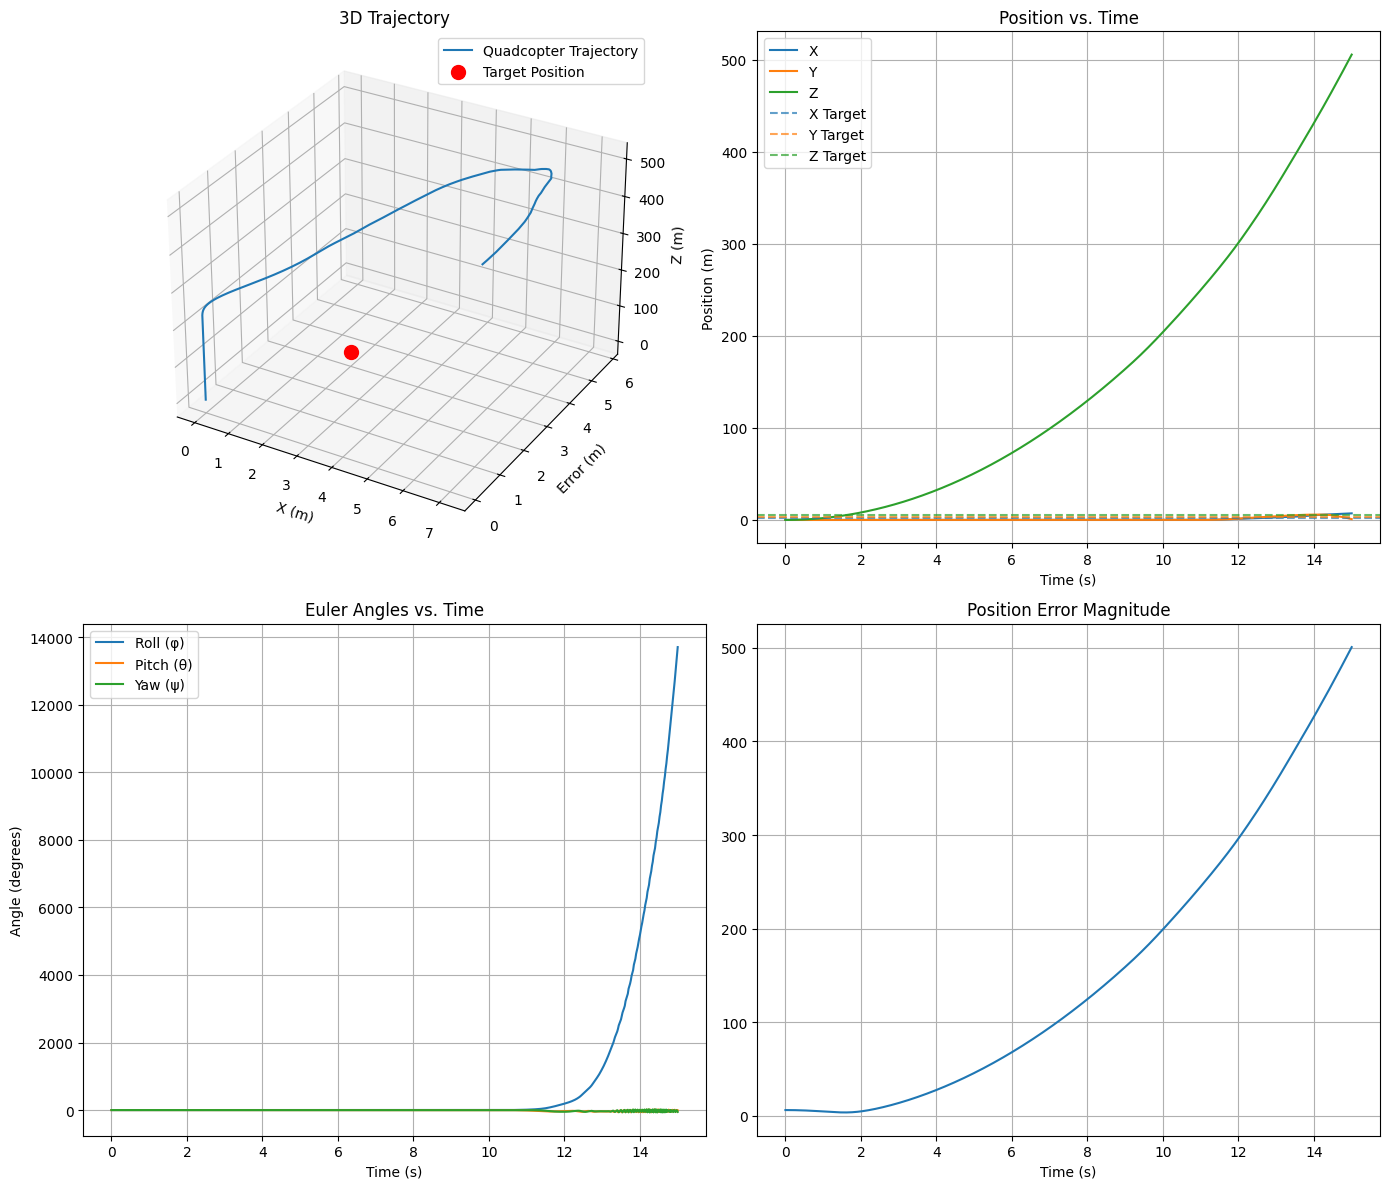

In [4]:
# Cell 4: Visualization of Results
def plot_results(gains):
    if gains is None:
        print("Cannot plot results, as optimization failed.")
        return

    print("\n📊 Generating plots with optimized gains...")
    target_pos = np.array([2.0, 3.0, 5.0])
    duration = 15.0 

    # Run the simulation one last time to get the full history
    solution, cost = run_simulation(gains, target_pos, duration, return_history=True)
    t = solution.t
    x, y, z, phi, theta, psi = solution.y[0], solution.y[1], solution.y[2], solution.y[3], solution.y[4], solution.y[5]

    # --- 3D Trajectory Plot ---
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(221, projection='3d')
    ax.plot(x, y, z, label='Quadcopter Trajectory')
    ax.scatter(target_pos[0], target_pos[1], target_pos[2], color='r', s=100, label='Target Position')
    ax.set_title('3D Trajectory')
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
    ax.legend()
    ax.grid(True)
    
    # --- Position vs. Time Plot ---
    ax2 = fig.add_subplot(222)
    ax2.plot(t, x, label='X')
    ax2.plot(t, y, label='Y')
    ax2.plot(t, z, label='Z')
    ax2.axhline(target_pos[0], color='C0', linestyle='--', alpha=0.7, label='X Target')
    ax2.axhline(target_pos[1], color='C1', linestyle='--', alpha=0.7, label='Y Target')
    ax2.axhline(target_pos[2], color='C2', linestyle='--', alpha=0.7, label='Z Target')
    ax2.set_title('Position vs. Time')
    ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Position (m)')
    ax2.legend()
    ax2.grid(True)
    
    # --- Angles vs. Time Plot ---
    ax3 = fig.add_subplot(223)
    ax3.plot(t, np.rad2deg(phi), label='Roll (φ)')
    ax3.plot(t, np.rad2deg(theta), label='Pitch (θ)')
    ax3.plot(t, np.rad2deg(psi), label='Yaw (ψ)')
    ax3.set_title('Euler Angles vs. Time')
    ax3.set_xlabel('Time (s)'); ax3.set_ylabel('Angle (degrees)')
    ax3.legend()
    ax3.grid(True)
    
    # --- Position Error Plot ---
    ax4 = fig.add_subplot(224)
    error = np.sqrt((x - target_pos[0])**2 + (y - target_pos[1])**2 + (z - target_pos[2])**2)
    ax4.plot(t, error)
    ax4.set_title('Position Error Magnitude')
    ax4.set_xlabel('Time (s)'); ax.set_ylabel('Error (m)')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

# --- Plot the final results ---
if 'optimal_gains' in locals():
    plot_results(optimal_gains)